In [1]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None

%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)
mpl.rcParams.update({'font.size':22})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print('Done')

Done


# Read real data

In [2]:
df_real = pd.read_csv('../Data/All_p_w_m.csv')
df_real.W = np.round(df_real.W, decimals=1)
df_real.sort_values(['P','Exp','W'], ascending=True, inplace=True)
df_real = df_real[['P','Exp','W','M']]
df_real.head()

,P,Exp,W,M
0,1,1,0.0,0.000000
1901,1,1,0.2,0.697278
3802,1,1,0.4,1.291415
5703,1,1,0.6,1.854972
7604,1,1,0.8,2.348394


# Read synthetic data

In [4]:
df_data = pd.read_csv('../Data/generated_Synthetic_exp_data.csv')
df_data = df_data[['P','Exp','W','M']]
print(df_data.shape)
df_data.head()

(2292606, 4)


,P,Exp,W,M
0,1,1,0.0,0.000000
1,1,1,0.1,0.425466
2,1,1,0.2,0.854374
3,1,1,0.3,1.281075
4,1,1,0.4,1.698411


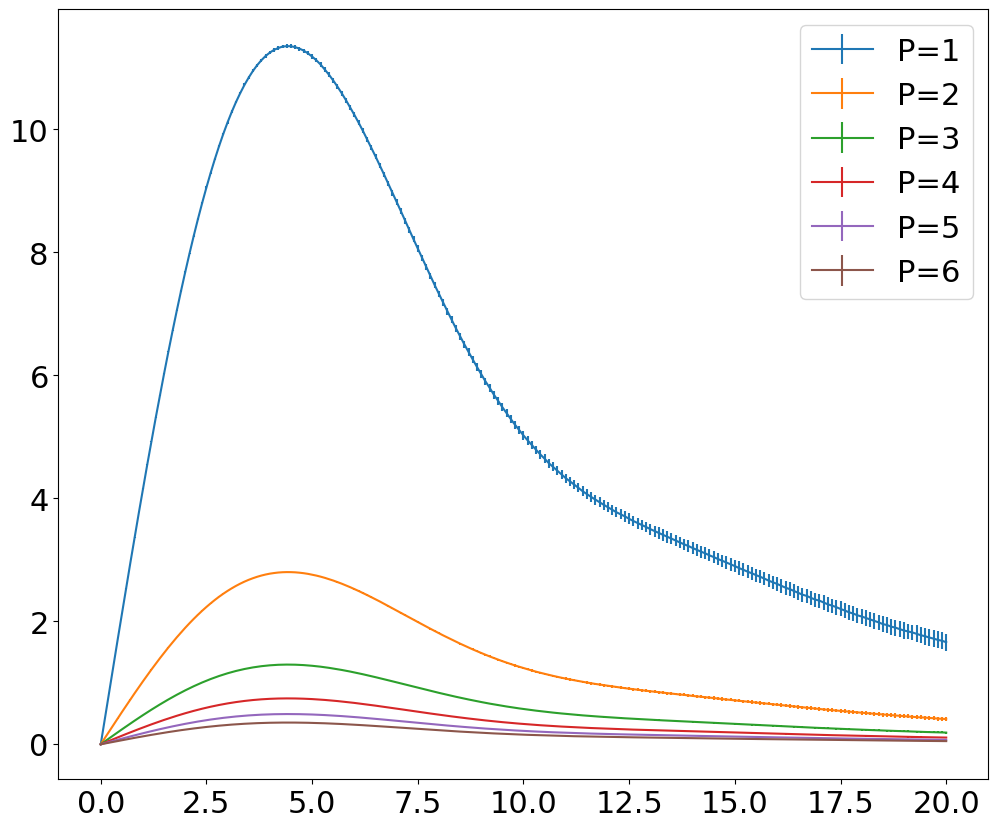

In [7]:
tmp1 = df_data.groupby(['P','W'])['M'].apply(lambda x: np.mean(x)).reset_index()
tmp1.columns = ['P','W','mean_M']
tmp2 = df_data.groupby(['P','W'])['M'].apply(lambda x: np.std(x)).reset_index()
tmp2.columns = ['P','W','std_M']

df = tmp1.merge(tmp2, on=['P','W'])

for p in range(1,7):
    tmp = df[df.P==p]
    plt.errorbar(tmp.W, tmp.mean_M, tmp.std_M,label=f"P={p}")
plt.legend()
plt.show()

# Prepare training data using whole synthetic data

In [8]:
tmp_df = []
for p in range(1,7):
    for exp in range(1,1902):
        tmp = df_data[np.logical_and(df_data.P==p, df_data.Exp==exp)]
        tmp.sort_values(['W'], ascending=True, inplace=True)
        tmp.reset_index(drop=True, inplace=True)

        for i in range(0, 197):
            tmp_df.append([p,exp,tmp.W[i],tmp.M[i],tmp.W[i+1],tmp.M[i+1],tmp.W[i+2],tmp.M[i+2],tmp.W[i+3],tmp.M[i+3],tmp.W[i+4],tmp.M[i+4]])
    
    print('{} done.'.format(p))

df_train = pd.DataFrame(tmp_df,columns=['P','Exp','w1','m1','w2','m2','w3','m3','w4','m4','w5','target'])
del [tmp_df]
df_train.P = df_train.P.astype(int)
df_train.Exp = df_train.Exp.astype(int)
df_train.to_csv('../Data/Synthetic_train_data.csv', index=False)
df_train.head()

1 done.
2 done.
3 done.
4 done.
5 done.
6 done.


,P,Exp,w1,m1,w2,m2,w3,m3,w4,m4,w5,target
0,1,1,0.0,0.000000,0.1,0.425466,0.2,0.854374,0.3,1.281075,0.4,1.698411
1,1,1,0.1,0.425466,0.2,0.854374,0.3,1.281075,0.4,1.698411,0.5,2.123796
2,1,1,0.2,0.854374,0.3,1.281075,0.4,1.698411,0.5,2.123796,0.6,2.534114
3,1,1,0.3,1.281075,0.4,1.698411,0.5,2.123796,0.6,2.534114,0.7,2.956729
4,1,1,0.4,1.698411,0.5,2.123796,0.6,2.534114,0.7,2.956729,0.8,3.359172


## Prepare test data using real and test data for the first values of $\omega$

In [9]:
real_filled = []
rmatch = []

df_data.sort_values(['P','Exp','W'], ascending=True, inplace=True)
df_real.sort_values(['P','Exp','W'], ascending=True, inplace=True)

for p in range(1,7):
    for exp in range(1, 1901):
        gen = df_data.loc[np.logical_and(df_data.P==p, df_data.Exp==exp), ['W','M']]
        real = df_real.loc[np.logical_and(df_real.P==p, df_real.Exp==exp), ['W','M']]
        
        i=0
        rm = 0
        for w in gen.W.unique():
            i+=1
            if i==5:
                break
                
            m = gen.M[gen.W==w].values[0]
            if w in real.W:
                m = real.M[real.W==w].values[0]
                rm+=1
                
            real_filled.append([p, exp, w, m])
        rmatch.append([p,exp,rm])
            
df_real_filled = pd.DataFrame(real_filled, columns=['P','Exp','W','M'])
df_real_filled.sample(10)

,P,Exp,W,M
19740,3,1136,0.0,0.000000
12608,2,1253,0.0,0.000000
28242,4,1361,0.2,0.055954
37369,5,1743,0.1,0.018394
14019,2,1605,0.3,0.315482
3608,1,903,0.0,0.000000
38992,6,249,0.0,0.000000
44392,6,1599,0.0,0.000000
6908,1,1728,0.0,0.000000
18184,3,747,0.0,0.000000


In [ ]:
t = pd.DataFrame(rmatch, columns=mns=['P','Exp','cnt'])
